## Please Upvote if you Find this Useful :)

In [1]:
!pip install -q segmentation_models_pytorch
!pip install -qU wandb
!pip install -q scikit-learn==1.0

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1733 lines of output]
      Partial import of sklearn during the build process.
      C compiler: gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC
      
      compile options: '-c'
      gcc: test_program.c
      gcc -pthread -B /opt/conda/compiler_compat objects/test_program.o -o test_program
      C compiler: gcc -pthread -B /opt/conda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/conda/include -fPIC -O2 -isystem /opt/conda/include -fPIC
      
      compile options: '-c'
      extra options: '-fopenmp'
      gcc: test_program.c
      gcc -pthread -B /opt/conda/compiler_compat objects/test_program.o -o test_program -fopenmp
      Compiling sklearn/__check_build/_che

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
class CFG:
    seed = 101
    debug = False  # set debug=False for Full Training
    exp_name = 'ma-net-resnet50-160x192-ep=15'
    comment = 'ma-net with resnet50 encoder ep=15'
    model_name = 'MA-Net'
    backbone = 'resnet50'  # Default backbone
    train_bs = 64
    valid_bs = train_bs * 2
    img_size = [160, 192]
    epochs = 10
    lr = 1e-4
    scheduler = 'CosineAnnealingLR'
    min_lr = 1e-6
    T_max = int(30000 / train_bs * epochs) + 50
    T_0 = 25
    warmup_epochs = 0
    wd = 1e-6
    n_accumulate = max(1, 32 // train_bs)
    n_fold = 5
    folds = [0]
    num_classes = 3
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

available_backbones = ['resnet50', 'mobilenet_v2']  # Available backbones

In [6]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [7]:
path_df = pd.DataFrame(glob('/kaggle/input/uwmgi-25d-stride2-dataset/images/images/*'), columns=['image_path'])
path_df['mask_path'] = path_df.image_path.str.replace('image','mask')
path_df['id'] = path_df.image_path.map(lambda x: x.split('/')[-1].replace('.npy',''))
path_df.head()

,image_path,mask_path,id
0,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case130_day20_slice_0131
1,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case49_day0_slice_0055
2,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case110_day16_slice_0024
3,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case2_day4_slice_0119
4,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...,case141_day27_slice_0066


In [8]:
df = pd.read_csv('../input/uwmgi-mask-dataset/train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks

df = df.drop(columns=['image_path','mask_path'])
df = df.merge(path_df, on=['id'])
df.head()

,id,case,day,slice,height,width,segmentation,rle_len,empty,image_path,mask_path
0,case123_day20_slice_0001,123,20,1,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
1,case123_day20_slice_0002,123,20,2,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
2,case123_day20_slice_0003,123,20,3,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
3,case123_day20_slice_0004,123,20,4,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
4,case123_day20_slice_0005,123,20,5,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...


In [9]:
fault1 = 'case7_day0'
fault2 = 'case81_day30'
df = df[~df['id'].str.contains(fault1) & ~df['id'].str.contains(fault2)].reset_index(drop=True)
df.head()

,id,case,day,slice,height,width,segmentation,rle_len,empty,image_path,mask_path
0,case123_day20_slice_0001,123,20,1,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
1,case123_day20_slice_0002,123,20,2,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
2,case123_day20_slice_0003,123,20,3,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
3,case123_day20_slice_0004,123,20,4,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...
4,case123_day20_slice_0005,123,20,5,266,266,"[, , ]",0,True,/kaggle/input/uwmgi-25d-stride2-dataset/images...,/kaggle/input/uwmgi-25d-stride2-dataset/masks/...


In [10]:
df['empty'].value_counts().plot.bar()

In [11]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

In [12]:
def load_img(path):
    img = np.load(path)
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [13]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [14]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3374
      True     4706
1.0   False    4112
      True     4896
2.0   False    2973
      True     3827
3.0   False    3407
      True     4689
4.0   False    2627
      True     3597
Name: id, dtype: int64

In [15]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

In [16]:
data_transforms = {
    "train": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [17]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [18]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)

In [19]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 320, 384]), torch.Size([20, 3, 320, 384]))

In [20]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

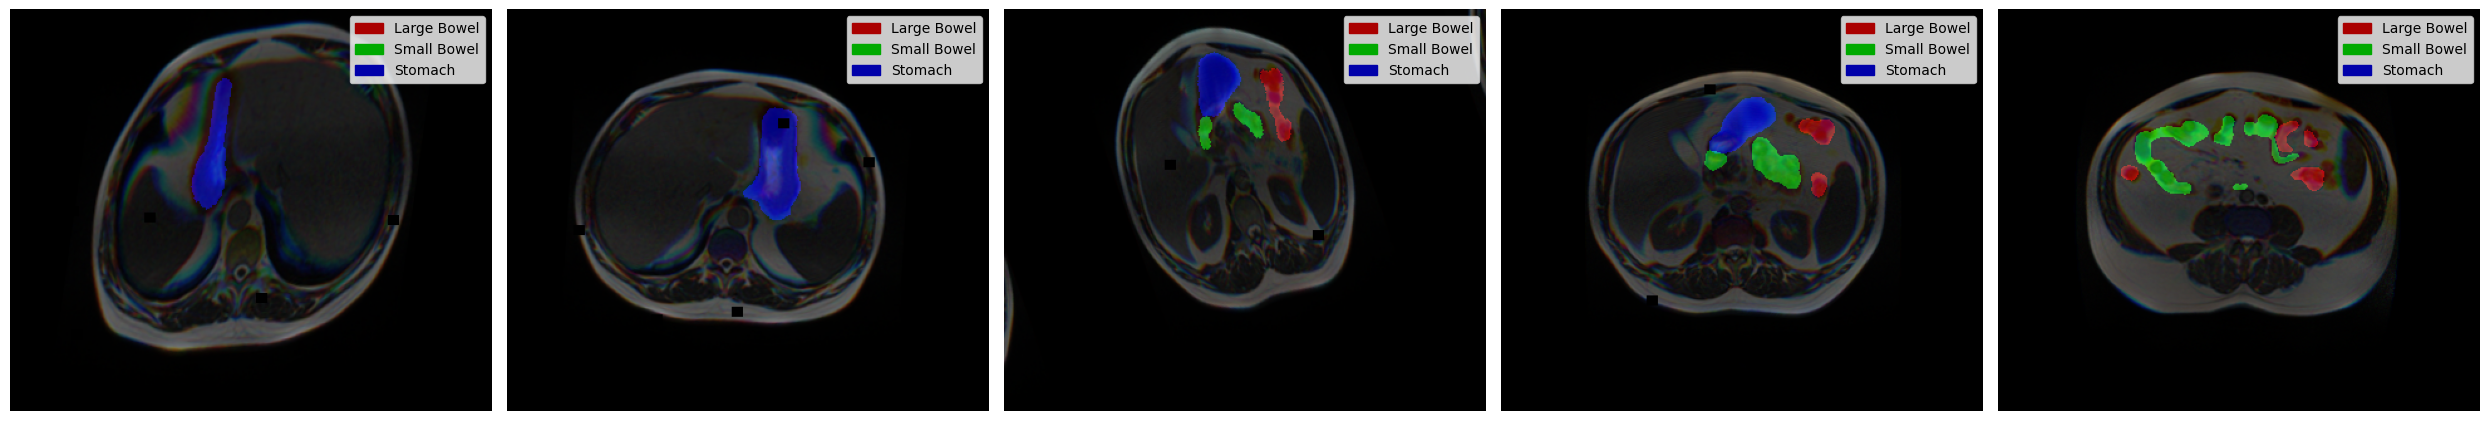

In [21]:
plot_batch(imgs, msks, size=5)

In [22]:
import gc
gc.collect()

12245

In [23]:
import segmentation_models_pytorch as smp

def build_model():
        model = smp.MAnet(
            encoder_name='mobilenet_v2',
            encoder_weights="imagenet",
            in_channels=3,
            classes=CFG.num_classes,
            activation=None,
        )
        model.to(CFG.device)
        return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path, map_location=CFG.device))
    model.eval()
    return model

# 🔧 Loss Function

In [24]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        torch.cuda.empty_cache()
        gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [26]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [27]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [28]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [29]:
import segmentation_models_pytorch as smp
print(dir(smp))

['DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus', '_Optional', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_torch', 'base', 'create_model', 'datasets', 'decoders', 'encoders', 'losses', 'metrics']


In [30]:
import aiohttp
print(aiohttp.__version__)

3.9.1


In [31]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 100MB/s] 


# 🚅 Training

In [32]:
for fold in CFG.folds:
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

wandb: Currently logged in as: niks-srigiri (hochschule-luzern). Use `wandb login --relogin` to force relogin


###############
### Fold: 0
###############


cuda: Tesla T4

Epoch 1/10

Valid : 100%|██████████| 64/64 [01:06<00:00,  1.03s/it, gpu_memory=8.28 GB, lr=0.00010, valid_loss=0.5192]


Valid Dice: 0.6767 | Valid Jaccard: 0.6384
Valid Score Improved (-inf ---> 0.6767)
Model Saved


Epoch 2/10

Valid : 100%|██████████| 64/64 [01:07<00:00,  1.06s/it, gpu_memory=8.29 GB, lr=0.00009, valid_loss=0.3187]


Valid Dice: 0.8509 | Valid Jaccard: 0.8138
Valid Score Improved (0.6767 ---> 0.8509)
Model Saved


Epoch 3/10

Valid : 100%|██████████| 64/64 [01:02<00:00,  1.02it/s, gpu_memory=8.50 GB, lr=0.00008, valid_loss=0.1831]


Valid Dice: 0.8773 | Valid Jaccard: 0.8440
Valid Score Improved (0.8509 ---> 0.8773)
Model Saved


Epoch 4/10

Valid : 100%|██████████| 64/64 [01:03<00:00,  1.01it/s, gpu_memory=8.50 GB, lr=0.00007, valid_loss=0.1599]


Valid Dice: 0.8750 | Valid Jaccard: 0.8428


Epoch 5/10

Valid : 100%|██████████| 64/64 [01:01<00:00,  1.03it/s, gpu_memory=8.35 GB, lr=0.00005, valid_loss=0.1510]


Valid Dice: 0.8846 | Valid Jaccard: 0.8532
Valid Score Improved (0.8773 ---> 0.8846)
Model Saved


Epoch 6/10

Valid : 100%|██████████| 64/64 [01:03<00:00,  1.00it/s, gpu_memory=8.48 GB, lr=0.00004, valid_loss=0.1486]


Valid Dice: 0.8864 | Valid Jaccard: 0.8553
Valid Score Improved (0.8846 ---> 0.8864)
Model Saved


Epoch 7/10

Valid : 100%|██████████| 64/64 [01:06<00:00,  1.05s/it, gpu_memory=8.42 GB, lr=0.00002, valid_loss=0.1451]


Valid Dice: 0.8885 | Valid Jaccard: 0.8572
Valid Score Improved (0.8864 ---> 0.8885)
Model Saved


Epoch 8/10

Valid : 100%|██████████| 64/64 [01:01<00:00,  1.03it/s, gpu_memory=8.41 GB, lr=0.00001, valid_loss=0.1428]


Valid Dice: 0.8896 | Valid Jaccard: 0.8585
Valid Score Improved (0.8885 ---> 0.8896)
Model Saved


Epoch 9/10

Valid : 100%|██████████| 64/64 [01:01<00:00,  1.03it/s, gpu_memory=8.48 GB, lr=0.00000, valid_loss=0.1427]


Valid Dice: 0.8933 | Valid Jaccard: 0.8629
Valid Score Improved (0.8896 ---> 0.8933)
Model Saved


Epoch 10/10

Valid : 100%|██████████| 64/64 [01:05<00:00,  1.03s/it, gpu_memory=8.42 GB, lr=0.00000, valid_loss=0.1415]


Valid Dice: 0.8928 | Valid Jaccard: 0.8622


Training complete in 2h 9m 4s
Best Score: 0.8629


LR,█▇▇▆▅▄▃▂▁▁
Train Loss,█▅▂▁▁▁▁▁▁▁
Valid Dice,▁▇▇▇██████
Valid Jaccard,▁▆▇▇██████
Valid Loss,█▄▂▁▁▁▁▁▁▁
Best Dice,0.89327
Best Epoch,9
Best Jaccard,0.86287
LR,0.0
Train Loss,0.07706
Valid Dice,0.89281


In [33]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=False, 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in CFG.folds:
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [34]:
# Function to visualize a batch of images, masks, and predictions
def plot_comparison(imgs, true_masks, preds, size=5):
    plt.figure(figsize=(20, size * 5))
    for idx in range(size):
        img = imgs[idx,].permute((1, 2, 0)).numpy() * 255.0
        img = img.astype('uint8')
        
        true_msk = true_masks[idx,].permute((1, 2, 0)).numpy() * 255.0
        pred_msk = preds[idx,].permute((1, 2, 0)).numpy() * 255.0

        # Display original image
        plt.subplot(size, 5, idx * 5 + 1)
        plt.imshow(img, cmap='bone')
        plt.axis('off')
        plt.title("Original Image")
        
        # Display ground truth mask
        plt.subplot(size, 5, idx * 5 + 2)
        show_img(img, true_msk)
        plt.axis('off')
        plt.title("Ground Truth Mask")
        
        # Display predicted mask
        plt.subplot(size, 5, idx * 5 + 3)
        show_img(img, pred_msk)
        plt.axis('off')
        plt.title("Predicted Mask")
        
         # Display ground truth mask only
        plt.subplot(size, 5, idx * 5 + 4)
        plt.imshow(true_msk)
        plt.axis('off')
        plt.title("Ground Truth Mask Only")
        
        # Display separate predicted masks
        plt.subplot(size, 5, idx * 5 + 5)
        for i in range(pred_msk.shape[-1]):
            plt.imshow(pred_msk[..., i], alpha=0.5, cmap='viridis')
        plt.axis('off')
        plt.title("Separate Predicted Masks")
    
    plt.tight_layout()
    plt.show()

# Create a function to fetch both the images and masks together for correct comparison
def fetch_images_and_masks(df, fold, size=5):
    dataset = BuildDataset(df.query("fold==@fold & empty==0").sample(size), transforms=data_transforms['valid'])
    loader  = DataLoader(dataset, batch_size=size, shuffle=False, num_workers=4, pin_memory=True)
    return next(iter(loader))

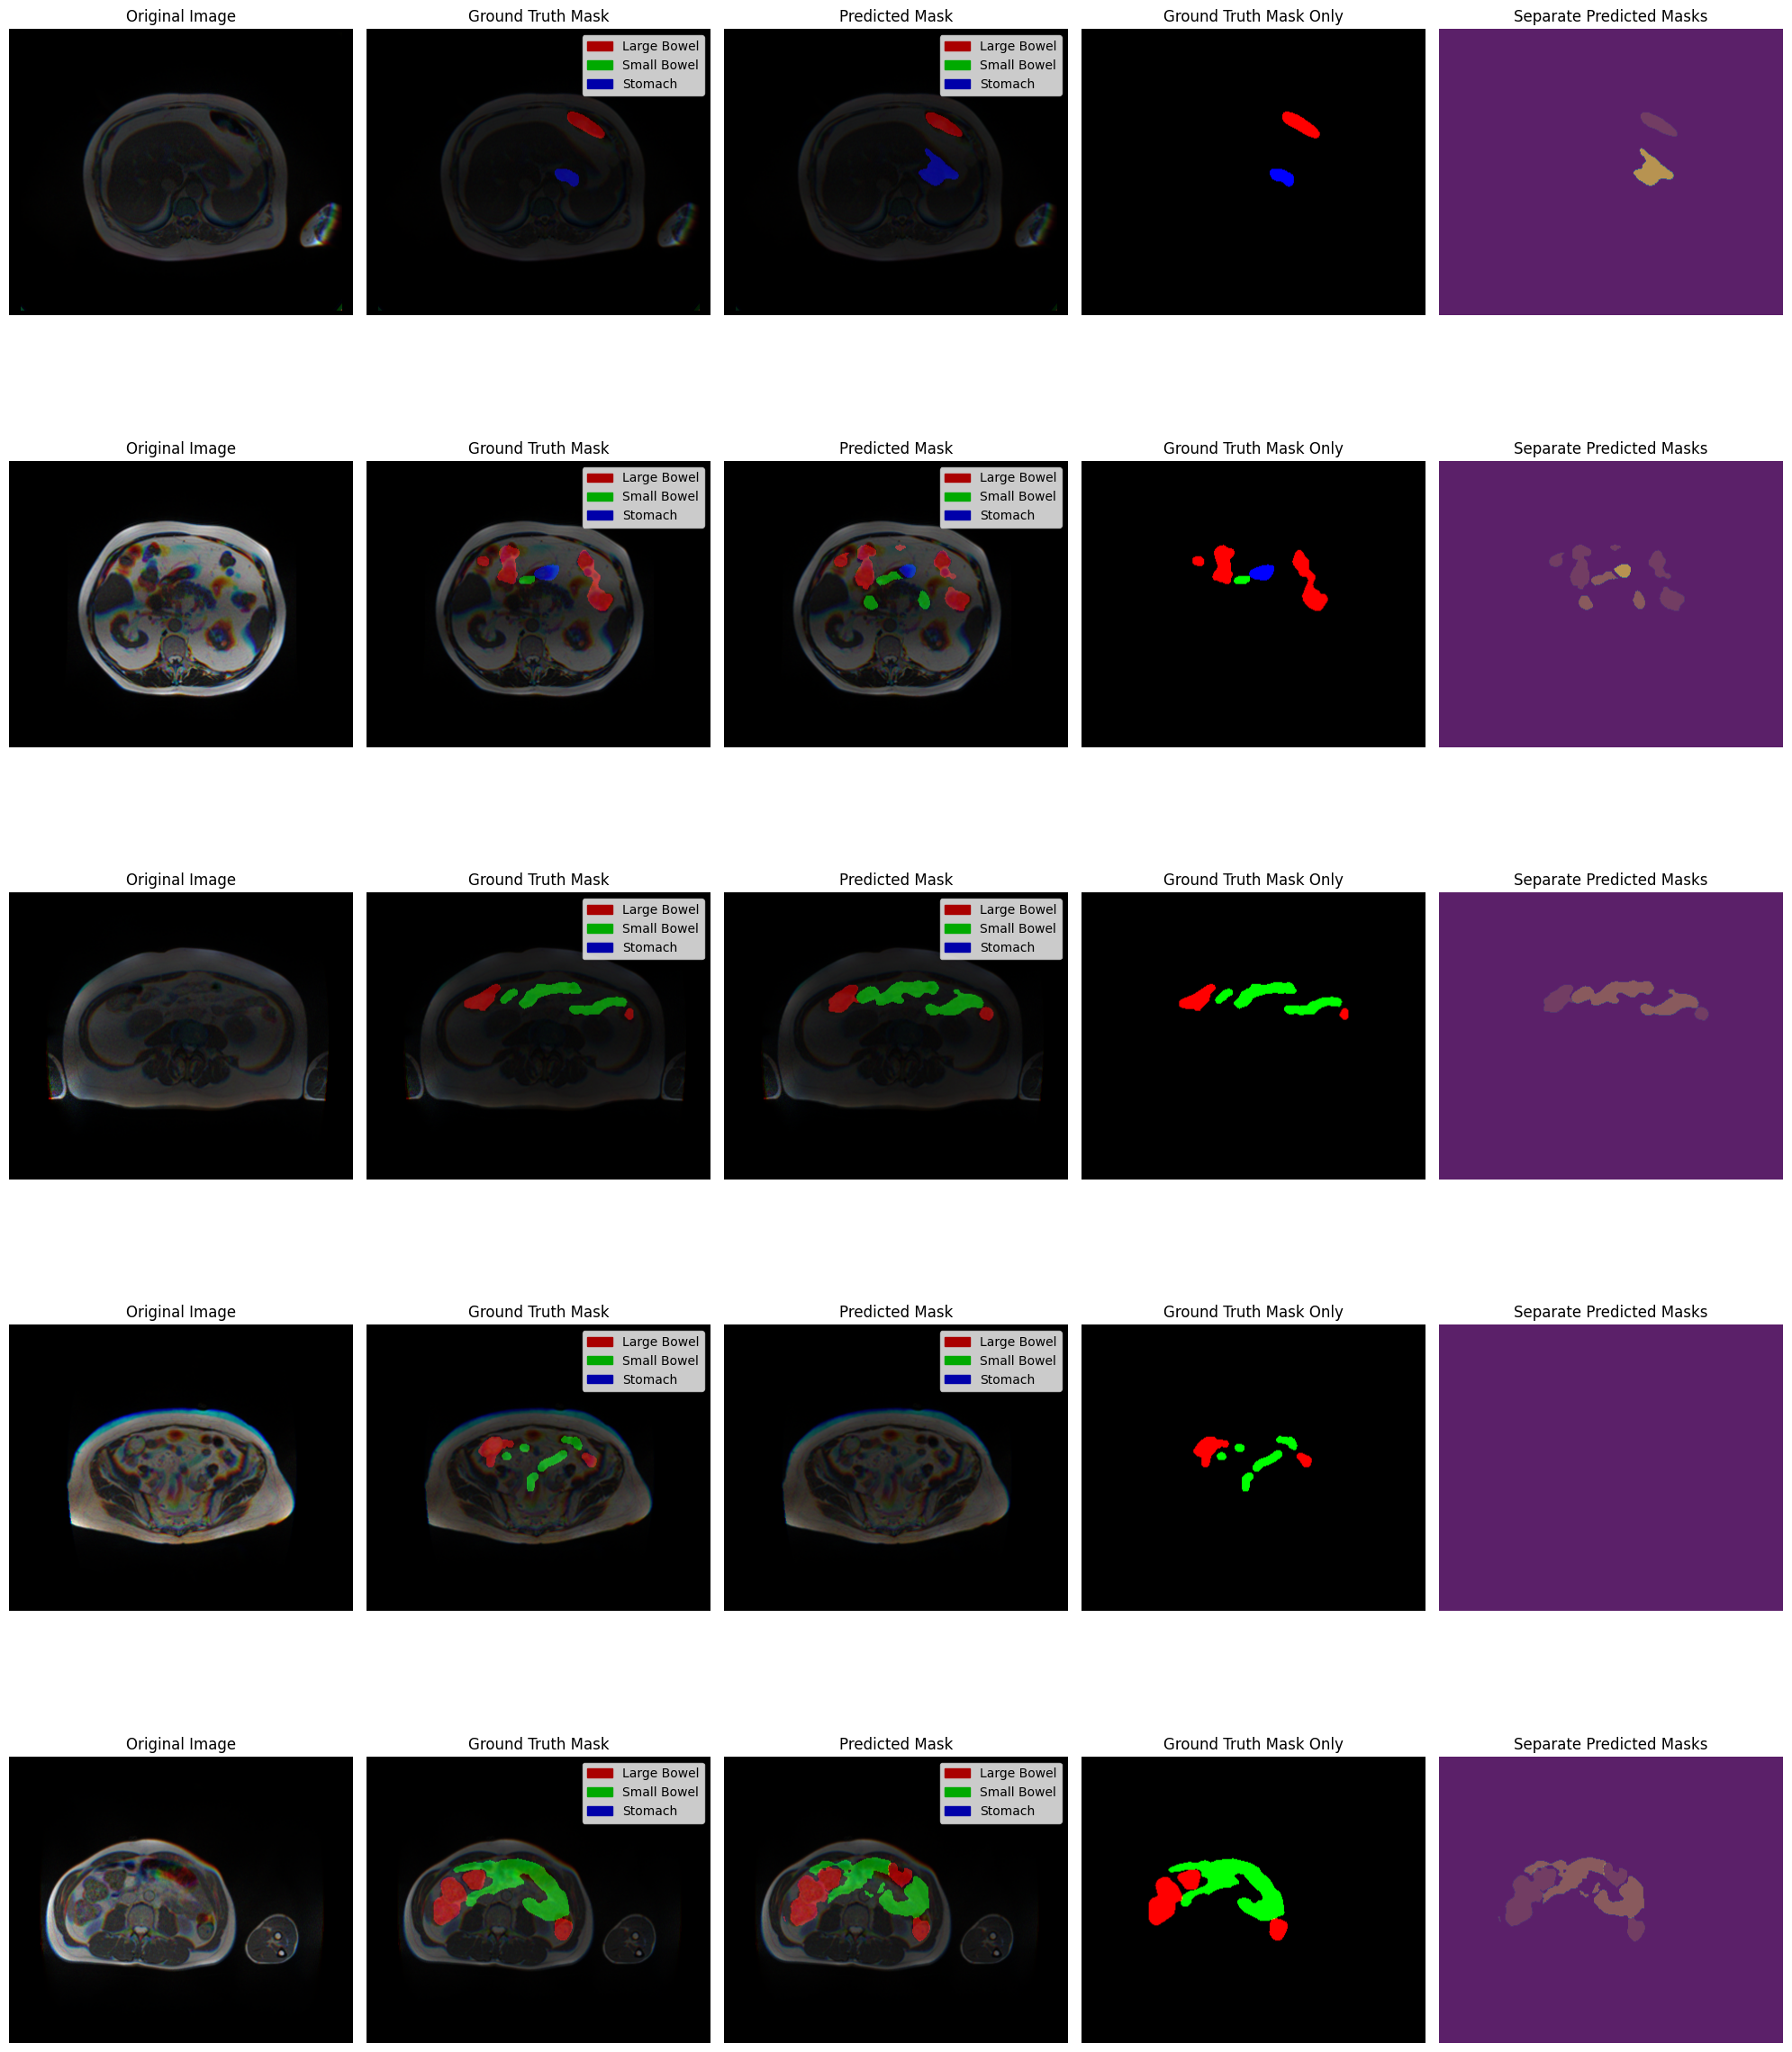

In [35]:
# Plot correct and incorrect predictions
fold = 0
size = 5

# Fetch images and corresponding ground truth masks
imgs, msks = fetch_images_and_masks(df, fold, size=size)
imgs = imgs.to(CFG.device, dtype=torch.float)

# Load model predictions
preds = []
for fold in CFG.folds:
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred) > 0.5).double()
    preds.append(pred)

imgs  = imgs.cpu().detach()
msks  = msks.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

# Plot the comparison
plot_comparison(imgs, msks, preds, size=size)

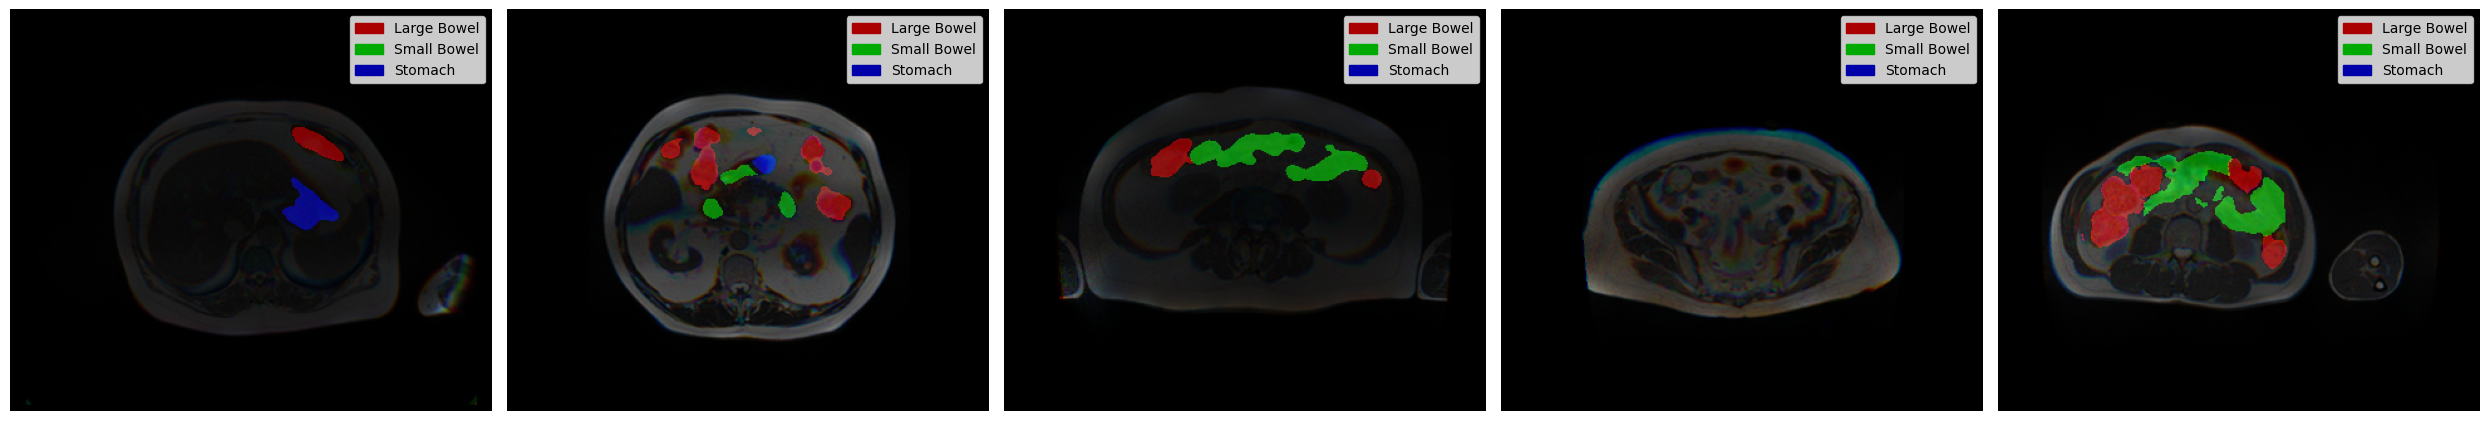

In [36]:
plot_batch(imgs, preds, size=5)

In [37]:
!rm -r ./wandb